# Generative Adverserial Networks
Generative adversarial networks (GANs) are algorithmic architectures that use two neural networks, pitting one against the other (thus the “adversarial”) in order to generate new, synthetic instances of data that can pass for real data. They are used widely in image generation, video generation and voice generation.



While most deep generative models are trained by maximizing log likelihood or a lower bound on log likelihood, GANs take a radically different approach that does not require inference or explicit calculation of the data likelihood. Instead, two models are used to solve a minimax game: a generator which samples data, and a discriminator which classifies the data as real or generated.In theory these models are capable of modeling an arbitrarily complex probability distribution.

# Objective:
**The objective of creating a simple GAN using the MNIST fashion dataset with TensorFlow is to generate new images of clothing items that are similar to the ones in the training set. This can be done by training a generator model to create new images and a discriminator model to distinguish between real and fake images. The generator model is trained to maximize the likelihood of the discriminator model classifying its output as real, while the discriminator model is trained to minimize this likelihood. As the models are trained, they learn to generate more realistic images and to distinguish between real and fake images more accurately.**

# **Introduction**


GANs are made up of two components - 

1. **Generator - generates new data instances**

2. **Discriminator - tries to distinguish the generated or fake data from the real dataset.**

Discriminative algorithms try to classify input data; that is, given the features of an instance of data, they predict a label or category to which that data belongs. So discriminative algorithms map features to labels. They are concerned solely with that correlation.One the other way,loosely speaking,generative algorithms do the opposite. Instead of predicting a label given certain features, they attempt to predict features given a certain label.

While training they both start together from scratch and the generator learn to shape the random distribition through the training epochs.

# **Training the network**

The important thing about training a GAN is that the two components should never be trained together. Rather the network is trained in two different phases,the first phase is for training the discriminator and updating the weights appropriately and in the next step the generator is trained while the discriminator training is disabled.

**Phase 1**
During phase one of training the generator is fed random data(in the form of a distribution) as noise. The generator creates some random images which are given to the discriminator. The discriminator also takes input from dataset of real images. 
The discriminator learns to distinguish the real data from the fake ones by learning or assessing features from it's inputs. The discriminator outputs some probability and difference between the predicted results and the actual results are backpropagated through the network and the weights of the discriminator is updated. 
Remember during this phase, the backpropagation stops at the end of the discriminator and the generator is not trained or updated.


**Phase 2**
In this phase, the generator produced batch of images are directly given as input to the discriminator. The real images are not given this time to the discriminator. The generator learns by tricking the discriminator into it outputting false positives. The discriminator outputs probabilities which are assessed against the actual results and the weights of of the generator are updated through backpropagation.
Remember here during backpropagation, the discriminator weights should not be updated and kept as they were before.

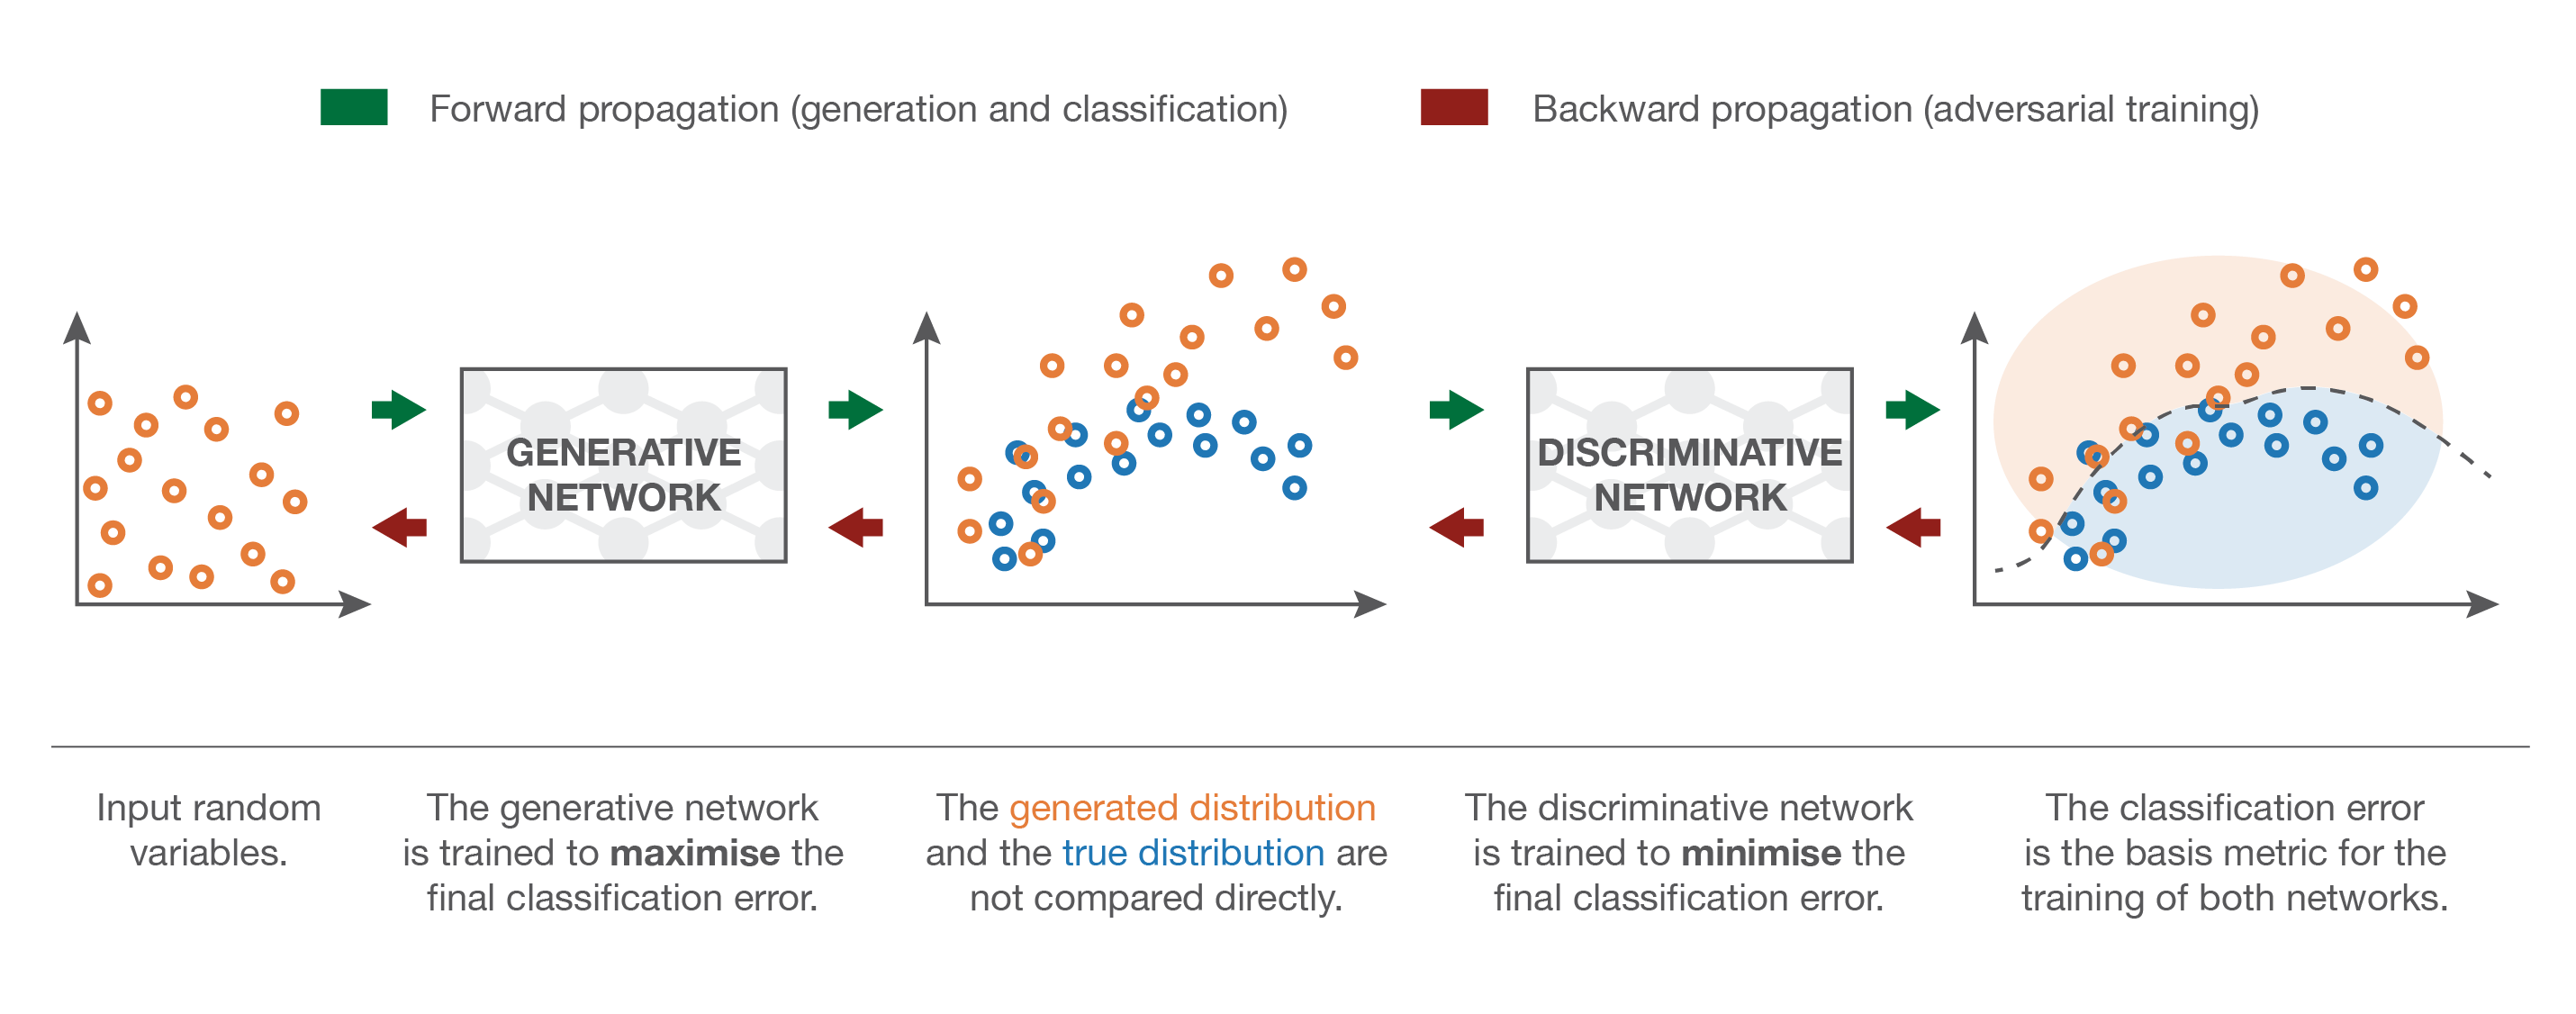

Loss Function:
Absolutely! Let's dive into the math of the simple GAN loss functions:

Discriminator Loss:

The most common discriminator loss is Binary Cross-Entropy (BCE) with sigmoid activation. Denoting:

x_i: A real data point
G(z_i): A fake data point generated by the generator from noise z_i
D(x_i): The discriminator's probability of x_i being real
D(G(z_i)): The discriminator's probability of G(z_i) being real
The BCE loss for a single data point is:

L_D(x_i) = -log(D(x_i)) - log(1 - D(G(z_i)))
This penalizes the discriminator when it mistakes a real point for fake or a fake point for real. To train the discriminator, we minimize the average loss over all data points:

min_D Σ L_D(x_i)
Generator Loss:

The simplest generator loss is the negative log of the discriminator's probability:

L_G(z_i) = -log(D(G(z_i)))
This directly encourages the generator to maximize the discriminator's belief that its generated data is real. Again, we minimize the average loss over all data points:

min_G Σ L_G(z_i)
However, as mentioned before, this can lead to saturation issues.

Alternative Loss Functions:

Wasserstein GAN (WGAN) Loss: This replaces BCE with a Wasserstein distance metric, leading to more stable training but removing the probability interpretation.
Non-Saturating GAN Loss: This replaces the negative log with the log of the discriminator's probability, avoiding saturation but requiring careful hyperparameter tuning.
These are just a few examples, and the specific formulas can vary depending on the chosen activation functions and distance metrics. The key takeaway is that the discriminator and generator losses work together to train each other through a game of "cat and mouse," ultimately leading to realistic data generation by the generator.

Remember, this is just a starting point. Feel free to ask if you'd like me to delve deeper into any specific aspect of the math or explore other loss functions!**LOSS FUNCTION of simple GAN**

In the paper that introduced GANs(link below in the reference), the generator tries to minimize the following function while the discriminator tries to maximize it:

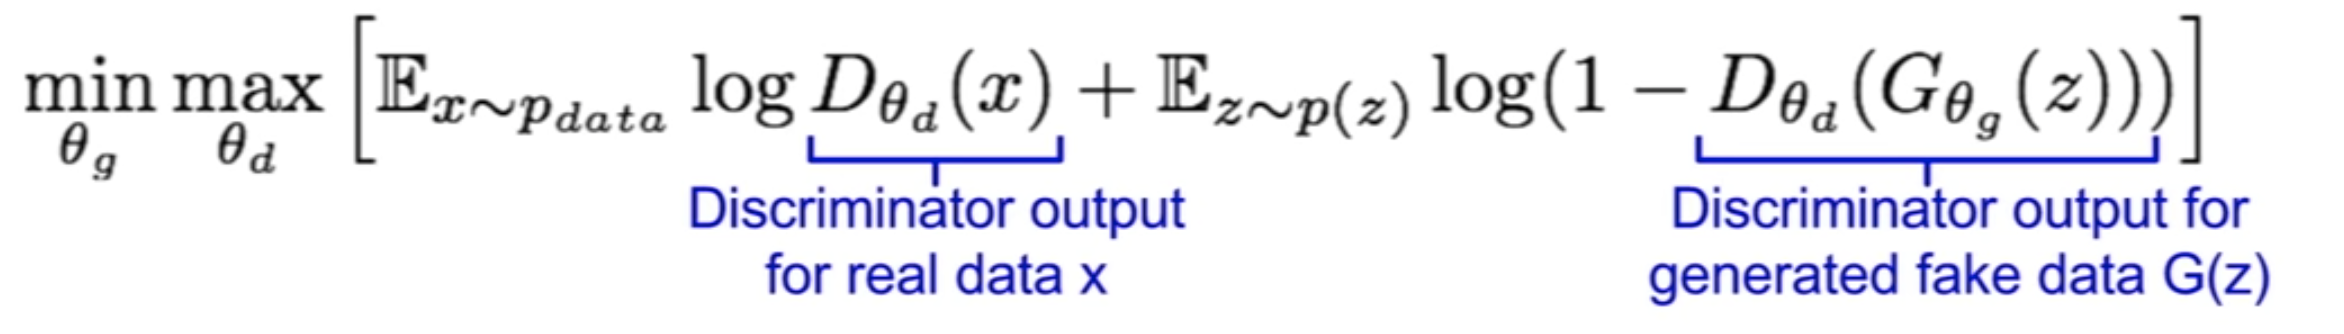
In this function:

* D(x) is the discriminator's estimate of the probability that real data instance x is real.
* Ex is the expected value over all real data instances.
* G(z) is the generator's output when given noise z.
* D(G(z)) is the discriminator's estimate of the probability that a fake instance is real.
* Ez is the expected value over all random inputs to the generator (in effect, the expected value over all generated fake instances G(z)).


The generator can't directly affect the log(D(x)) term in the function, so, for the generator, minimizing the loss is equivalent to minimizing log(1 - D(G(z))).

# **Let's begin**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


**Importing useful packages**

In [2]:
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf

Using TensorFlow backend.


# **Loading and Preprocessing the data**

In [3]:
train_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


dropping the labels from the dataset

In [8]:
X_train = train_data.drop('label',axis=1)
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X_train=X_train.values
print(X_train.shape)

(60000, 784)


In [10]:
X_train=X_train.reshape(-1,28,28,1)
print(X_train.shape)

(60000, 28, 28, 1)


# **Data Visualization**

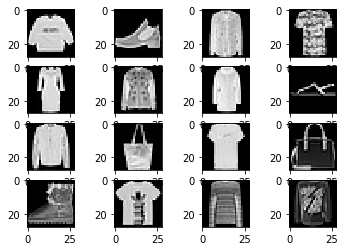

In [13]:
fig,axe=plt.subplots(4,4)
idx = 0
for i in range(4):
    for j in range(4):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=1

In [15]:
X_train =  X_train.astype('float32')

The pixel data ranges from 0 to 255 hence dividing each pixel by 255,i.e,normalizing the data such that the range is within 0 to 1.

In [16]:
X_train = X_train/255
X_train = X_train*2 - 1.

**NOTE**  after normalizing it is multiplied with 2 and substracted from 1 such that it ranges from (-1,1) because in DCGANs the last layer generative model activation is tanh which range is (-1,1) unlike sigmoid ranging (0,1) .

In [17]:
print(X_train.max(),X_train.min())

1.0 -1.0


# **Simple GAN Model**

**Generative part**

In [18]:
generator = Sequential()
generator.add(Dense(512,input_shape=[100]))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784))
generator.add(Reshape([28,28,1]))

Create Sequential Model:

generator = Sequential(): This line initializes a sequential model, a linear stack of layers, to construct the generator.

* Add Dense Layers:
    - generator.add(Dense(512, input_shape=[100])): Adds a dense layer with 512 neurons, taking a 100-dimensional vector as input. This layer starts -  the process of transforming the input noise into meaningful features.
    - generator.add(LeakyReLU(alpha=0.2)): Applies a LeakyReLU activation function, allowing for some information flow even for negative values. This helps prevent vanishing gradients during training.
    - generator.add(BatchNormalization(momentum=0.8)): Normalizes the activations of the previous layer, stabilizing the training process and accelerating convergence.

* Repeat for Additional Dense Layers:
    - The pattern of Dense layer, LeakyReLU, and BatchNormalization is repeated twice more, gradually decreasing the number of neurons to 256 and then 128. This creates a funnel-like structure, compressing the information into a more compact representation.

* Final Dense and Reshape Layers:
    - generator.add(Dense(784)): Adds a final dense layer with 784 neurons, corresponding to the flattened pixel values of a 28x28 image.
    - generator.add(Reshape([28, 28, 1])): Reshapes the output of the previous layer into a 3D array with dimensions (28, 28, 1), representing a grayscale image with 28x28 pixels and a single color channel.


In [19]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

 **Here's a breakdown of the model summary and parameter calculation:**

**Model Summary:**

- **Model Name:** sequential_1
- **Layers:** 10 layers, including Dense, LeakyReLU, BatchNormalization, and Reshape layers.
- **Output Shape:** (None, 28, 28, 1), indicating the model generates 28x28 grayscale images.

**Parameters:**

- **Total params:** 320,656, the total number of adjustable weights and biases in the model.
- **Trainable params:** 318,864, the parameters that are updated during training.
- **Non-trainable params:** 1,792, the parameters that remain fixed (e.g., in BatchNormalization layers).

**Parameter Calculation:**

- **Dense Layers:**
   - Parameters = (input_units * output_units) + output_units
     - Example: dense_1 has (100 * 512) + 512 = 51,712 parameters
- **LeakyReLU and Reshape Layers:**
   - Parameters = 0, as they don't have learnable weights or biases.
- **BatchNormalization Layers:**
   - Parameters = 2 * output_units, for the mean and variance variables.

**Calculation Example:**

- dense_2 parameters: (512 * 256) + 256 = 131,328
- batch_normalization_2 parameters: 2 * 256 = 512

**Key Points:**

- The number of parameters in a model affects its complexity and training speed.
- Trainable parameters are adjusted during training to learn patterns in the data.
- Non-trainable parameters are fixed and often used for regularization or normalization.
- Understanding parameter calculation is essential for designing and optimizing model architectures.


**Discriminatory part**

In [20]:
discriminator = Sequential()
discriminator.add(Dense(1,input_shape=[28,28,1]))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

**Here's a detailed explanation of the discriminator code:**

**Overall Functionality:**

- This code defines a neural network architecture called a **discriminator**, the other vital component of generative adversarial networks (GANs).
- The discriminator's role is to distinguish between real data samples and the fake data generated by the generator.

**Code Breakdown:**

1. **Import Necessary Library:**
   - Implicitly assumed is the import of `Sequential` from `tensorflow.keras.models` to create the model structure.

2. **Create Sequential Model:**
   - `discriminator = Sequential()`: Initializes a sequential model to construct the discriminator.

3. **Initial Dense and Flatten Layers:**
   - `discriminator.add(Dense(1, input_shape=[28, 28, 1]))`: Adds a dense layer with a single neuron, taking 28x28 grayscale images as input. This unusual starting structure is often used in GAN discriminators to learn a single, global feature for initial discrimination.
   - `discriminator.add(Flatten())`: Flattens the 2D image into a 1D vector for further processing by subsequent layers.

4. **Dense, LeakyReLU, and Dropout Layers:**
   - The pattern of Dense layer, LeakyReLU, and Dropout is repeated three times, gradually decreasing the number of neurons from 256 to 128 to 64. This creates a funnel-like structure, extracting key features and reducing dimensionality.
      - LeakyReLU introduces non-linearity for better learning.
      - Dropout randomly drops neurons during training to prevent overfitting.

5. **Final Dense and Sigmoid Layers:**
   - `discriminator.add(Dense(1, activation='sigmoid'))`: Adds a final dense layer with a single neuron and a sigmoid activation function. This outputs a probability between 0 and 1, indicating the likelihood of the input image being real.



In [21]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 28, 28, 1)         2         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               200960    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128)              

1. Compiling the discriminator layer
2. Compiling the GAN 

NOTE : the generator layer is not compiled seperately because it gets trained as part of the combined model but training the discriminator is necessary because it is trained before the combined model.

In [22]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [24]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [25]:
GAN.layers

In [26]:
GAN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         320656    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 242179    
Total params: 562,835
Trainable params: 318,864
Non-trainable params: 243,971
_________________________________________________________________


In [29]:
epochs = 30
batch_size = 100
noise_shape=100

Currently on Epoch 1
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600


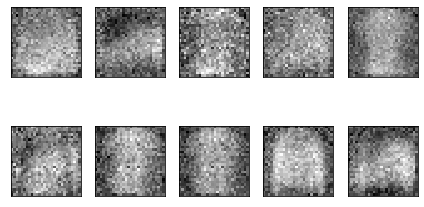

Currently on Epoch 2
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 3
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 4
	Currently on batch number 

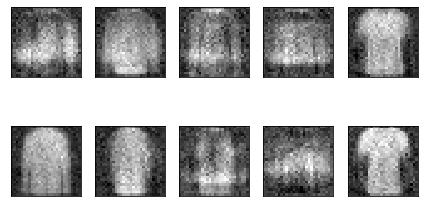

Currently on Epoch 12
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 13
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 14
	Currently on batch numb

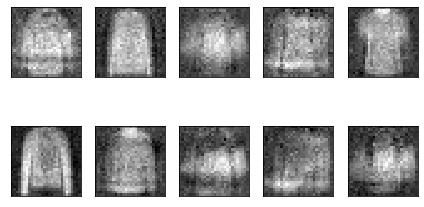

Currently on Epoch 22
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 23
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 24
	Currently on batch numb

In [30]:
# Designate GPU for model training (if available)
with tf.device('/gpu:0'):
    # Iterate through training epochs
    for epoch in range(epochs):
        print(f"Currently on Epoch {epoch+1}")

        # Iterate through batches of training data
        for i in range(X_train.shape[0] // batch_size):

            # Print progress update every 50 batches
            if (i + 1) % 50 == 0:
                print(f"\tCurrently on batch number {i+1} of {X_train.shape[0] // batch_size}")

            # Generate noise for generator input
            noise = np.random.normal(size=[batch_size, noise_shape])

            # Generate fake images using generator
            gen_image = generator.predict_on_batch(noise)

            # Prepare real image batch from training data
            train_dataset = X_train[i * batch_size:(i + 1) * batch_size]

            # Train discriminator on real images
            train_label = np.ones(shape=(batch_size, 1))  # Label real images as 1
            discriminator.trainable = True  # Allow discriminator to update weights
            d_loss_real = discriminator.train_on_batch(train_dataset, train_label)

            # Train discriminator on fake images
            train_label = np.zeros(shape=(batch_size, 1))  # Label fake images as 0
            d_loss_fake = discriminator.train_on_batch(gen_image, train_label)

            # Train generator
            noise = np.random.normal(size=[batch_size, noise_shape])  # Generate new noise
            train_label = np.ones(shape=(batch_size, 1))  # Aim to fool discriminator
            discriminator.trainable = False  # Freeze discriminator during generator training
            d_g_loss_batch = GAN.train_on_batch(noise, train_label)  # Train generator

        # Plot generated images every 10 epochs
        if epoch % 10 == 0:
            samples = 10  # Number of images to generate
            x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

            # Display generated images in a grid
            for k in range(samples):
                plt.subplot(2, 5, k + 1)
                plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')  # Reshape and display
                plt.xticks([])
                plt.yticks([])

            plt.tight_layout()
            plt.show()

print('Training is complete')


In [33]:
noise=np.random.normal(size=[10,noise_shape])

gen_image = generator.predict(noise)

noise generated using np.random.normal is given to as input to the generator. In the next step the generator produces batches of meaningful alike image from the random distribution.

Text(0.5, 1.0, 'How the noise looks')

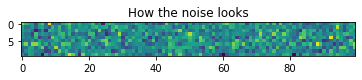

In [35]:
plt.imshow(noise)
plt.title('How the noise looks')

**Generator producing images from noise**

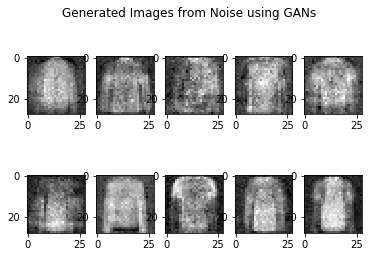

In [36]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1

**Inference from generated images**

As discussed before after iterating through few tens of epochs the generator learns to trick the discriminator with only one specific category of output image and hence stops learning beyond that point. The ouput after complete training is thus only single type of images almost similar in features ,i.e, shirts in this particular case and there is no variation in generated image features.

The above issue can be resolved using DCGANs as given below.

# **GAN using Deep Convolutions**

In this model we construct the generator using transpose convolution layers instead of simple dense layers which helps better in feature capturing and prevents the issue as described earlier. Similarly while building the discriminator layer,instead of simple dense units it uses convolution layers to increase efficiency of it's classification.


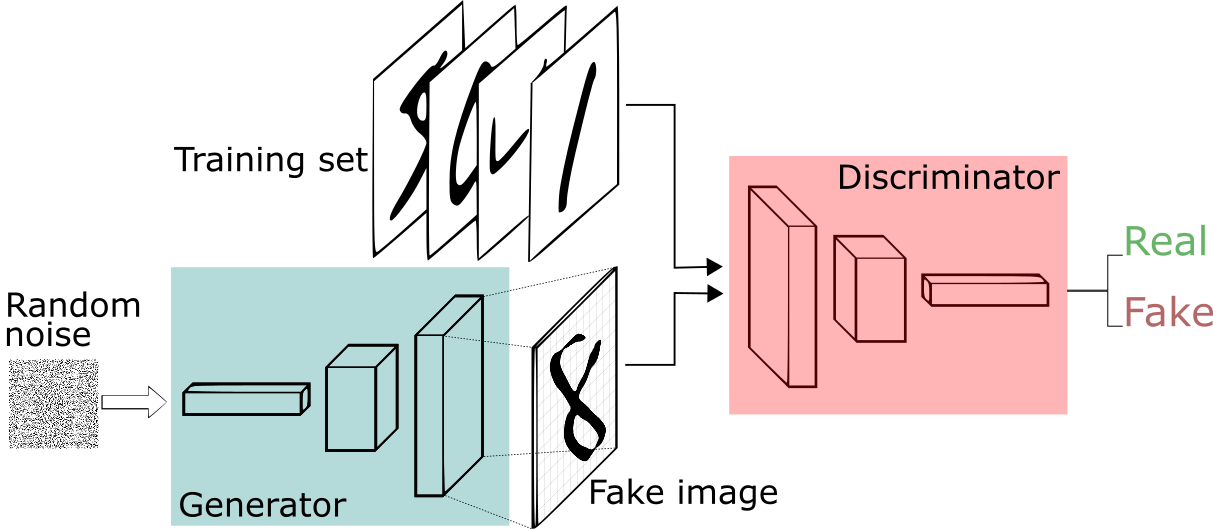


The paper that proposed this architecture https://arxiv.org/abs/1511.06434
To know more about Conv2D https://keras.io/layers/convolutional/

In [37]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[100]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))

In [38]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
______________________________________________

In [39]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

/opt/conda/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [40]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [41]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [42]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [43]:
GAN.layers

In [44]:
GAN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [46]:
epochs = 150 #vary epoch size as per required to train the model
batch_size = 100

In [48]:
noise_shape=100

Currently on Epoch 1
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600


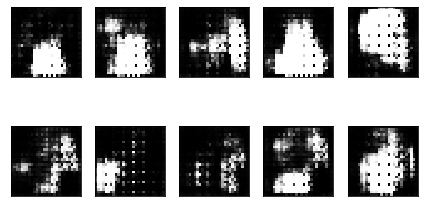

Currently on Epoch 2
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 3
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 4
	Currently on batch number 

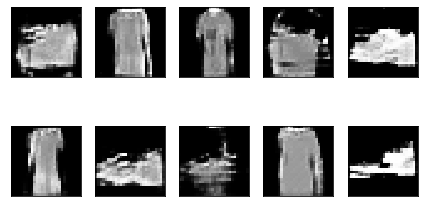

Currently on Epoch 12
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 13
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 14
	Currently on batch numb

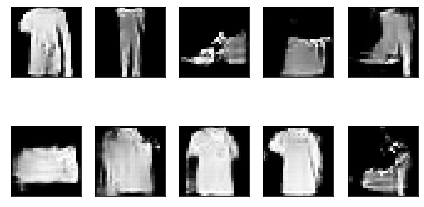

Currently on Epoch 22
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 23
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 24
	Currently on batch numb

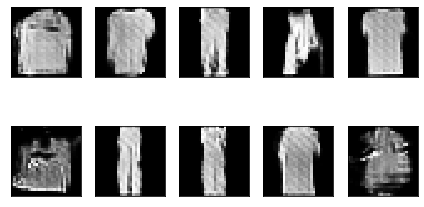

Currently on Epoch 32
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 33
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 34
	Currently on batch numb

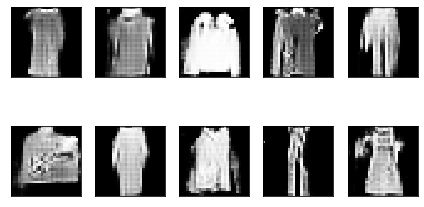

Currently on Epoch 42
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 43
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 44
	Currently on batch numb

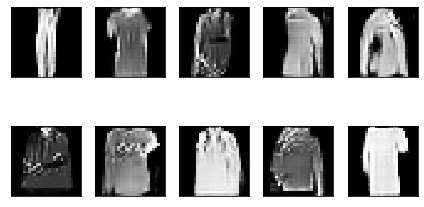

Currently on Epoch 52
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 53
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 54
	Currently on batch numb

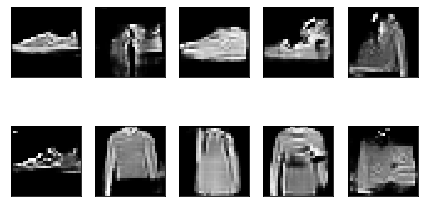

Currently on Epoch 62
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 63
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 64
	Currently on batch numb

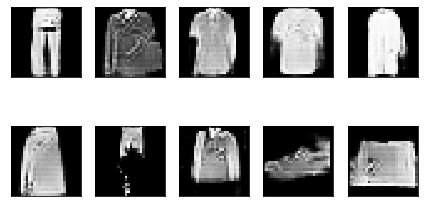

Currently on Epoch 72
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 73
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 74
	Currently on batch numb

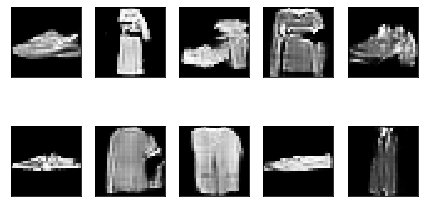

Currently on Epoch 82
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 83
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 84
	Currently on batch numb

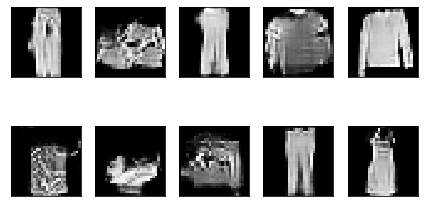

Currently on Epoch 92
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 93
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 94
	Currently on batch numb

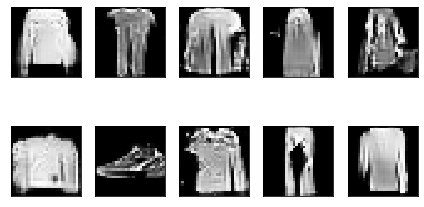

Currently on Epoch 102
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 103
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 104
	Currently on batch n

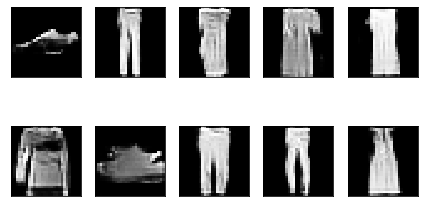

Currently on Epoch 112
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 113
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 114
	Currently on batch n

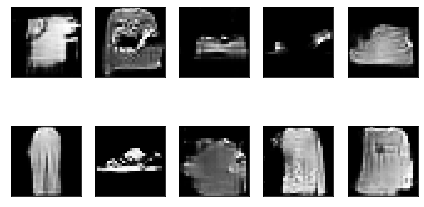

Currently on Epoch 122
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 123
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 124
	Currently on batch n

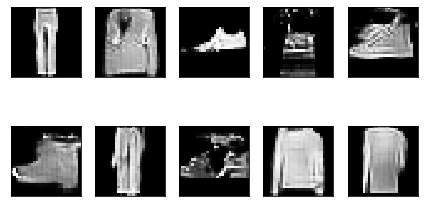

Currently on Epoch 132
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 133
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 134
	Currently on batch n

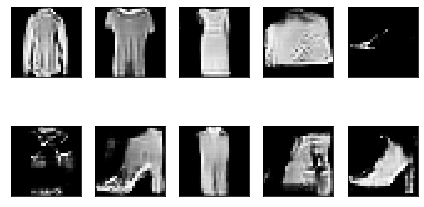

Currently on Epoch 142
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 143
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 144
	Currently on batch n

In [49]:

with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    
    for i in range(X_train.shape[0]//batch_size):
        
        if (i+1)%50 == 0:
            print(f"\tCurrently on batch number {i+1} of {X_train.shape[0]//batch_size}")
            
        noise=np.random.normal(size=[batch_size,noise_shape])
       
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
       
        #training discriminator on real images
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)
        
        #training discriminator on fake images
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)
        
        
        #training generator 
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False #while training the generator as combined model,discriminator training should be turned off
        
        d_g_loss_batch =GAN.train_on_batch(noise, train_label)
        
        
        
       
    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

        
        
print('Training is complete')

In [50]:
noise=np.random.normal(loc=0, scale=1, size=(100,noise_shape))

gen_image = generator.predict(noise)

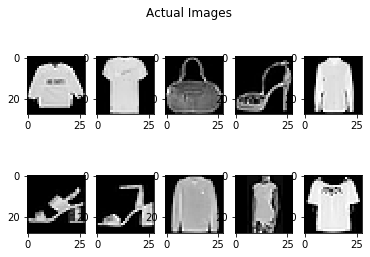

In [51]:
fig,axe=plt.subplots(2,5)
fig.suptitle("Actual Images")
idx = 0
for i in range(2):
    for j in range(5):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=10

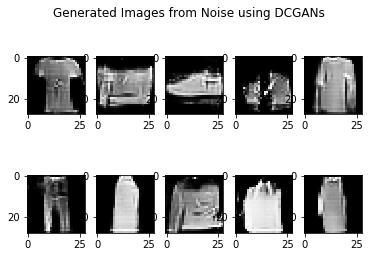

In [52]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using DCGANs')
idx=0
for i in range(2):
     for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=3

# **References**
0. Sayak : https://www.kaggle.com/sayakdasgupta
1. https://arxiv.org/abs/1406.2661 - GANs paper in 2014 by Ian J. Goodfellow and others.
2. https://arxiv.org/abs/1511.06434 - DCGANs in 2016
3. https://arxiv.org/pdf/1611.02163.pdf - 2017 ICLR paper 
4. https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29